# HSCT survival polynomial regression model

## Notebook set-up

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot
from sklearn.preprocessing import MinMaxScaler

# Figure out if we are in a Kaggle notebook or not based on the current
# path and set file paths accordingly
if os.getcwd() == '/kaggle/working':
    print('Running on Kaggle')
    training_features_file='/kaggle/input/hsct-survival-polynomial-regression/polynomial_training_features_df.parquet'
    training_labels_file='/kaggle/input/hsct-regression/training_labels_df.parquet'
    data_dictionary_file='/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv'
    model_file='/kaggle/input/hsct-survival-polynomial-regression/03.2-linear_regression_polynomial_features.pkl'
    polynomial_transformer_file='/kaggle/input/hsct-survival-polynomial-regression/03-poly_features_transformer.pkl'
    knn_imputer_file='/kaggle/input/hsct-regression/02-KNN_imputer.pkl'
    one_hot_encoder_file='/kaggle/input/hsct-regression/02-one_hot_encoder.pkl'
    testing_data_file='/kaggle/input/equity-post-HCT-survival-predictions/test.csv'
    submission_file='submission.csv'

else:
    training_features_file='../../data/processed/polynomial_training_features_df.parquet'
    training_labels_file='../../data/processed/training_labels_df.parquet'
    data_dictionary_file='../../data/raw/data_dictionary.csv'
    model_file='../../models/03.2-linear_regression_polynomial_features.pkl'
    polynomial_transformer_file='../../models/03-poly_features_transformer.pkl'
    knn_imputer_file='../../models/02-KNN_imputer.pkl'
    one_hot_encoder_file='../../models/02-one_hot_encoder.pkl'
    testing_data_file='../../data/raw/test.csv'
    submission_file='../predictions/polynomial_regression_submission.csv'

Running on Kaggle


## 1. Load assets

### 1.1. Data

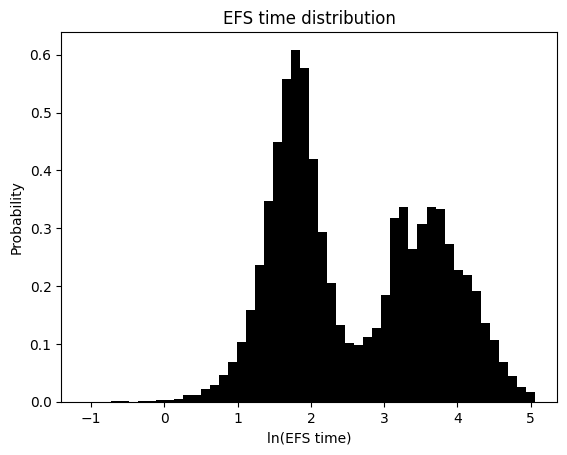

Training features: (28800, 16110)


In [2]:
training_features=pd.read_parquet(training_features_file)
training_labels=pd.read_parquet(training_labels_file)

# Extract and take the log of the labels
training_labels=np.log(training_labels['efs_time'])

plt.title('EFS time distribution')
plt.hist(training_labels, density=True, bins=50, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {training_features.shape}')

### 1.2. Models

In [3]:
with open(model_file, 'rb') as input_file:
    model=pickle.load(input_file)

with open(polynomial_transformer_file, 'rb') as input_file:
    poly=pickle.load(input_file)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2. Check model performance

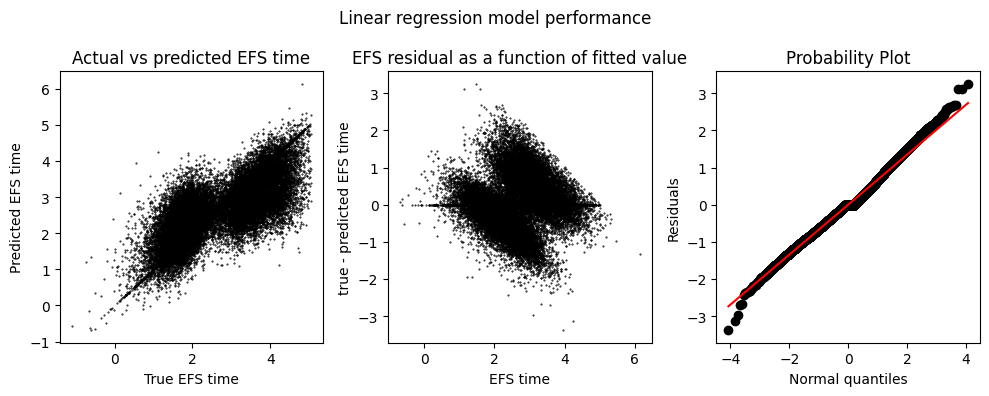

In [4]:
# Make predictions for the whole training set
predicted_efs_time=model.predict(training_features)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(training_labels, predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, training_labels - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
probplot(training_labels - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 3. Make test set predictions

### 3.1. Load test data & assets

In [5]:
# Load the one-hot encoder
with open(one_hot_encoder_file, 'rb') as input_file:
    encoder=pickle.load(input_file)

# Load the KNN imputer
with open(knn_imputer_file, 'rb') as input_file:
    imputer=pickle.load(input_file)

# Load testing data and column definitions
testing_data=pd.read_csv(testing_data_file)
data_dictionary=pd.read_csv(data_dictionary_file)

# Save the ID and drop
testing_ids=testing_data['ID']
testing_data.drop('ID', axis=1, inplace=True)
print(f'Testing features: {testing_data.shape}')

Testing features: (3, 57)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNNImputer from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 3.2. Split numeric and categorical features

In [6]:
# Get lists of categorical and numerical column names
categorical_feature_names=data_dictionary['variable'][data_dictionary['type'] == 'Categorical']
numerical_feature_names=data_dictionary['variable'][data_dictionary['type'] == 'Numerical']

# Remove the feature column from the column names lists
categorical_feature_names=categorical_feature_names[categorical_feature_names != 'efs']
numerical_feature_names=numerical_feature_names[numerical_feature_names != 'efs_time']

# Split the testing dataframe
testing_categorical_df=testing_data[categorical_feature_names].copy()
testing_numerical_df=testing_data[numerical_feature_names].copy()

print(f'Testing numerical features: {testing_numerical_df.shape}')
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing numerical features: (3, 22)
Testing categorical features: (3, 35)


### 3.3. Handle missing data

#### 3.3.1. Categorical features

In [7]:
# Replace NAN with 'Missing' string
testing_categorical_df.fillna('Missing', inplace=True)
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing categorical features: (3, 35)


#### 3.3.2. Numerical features

In [8]:
# Fill missing data
testing_numerical_data=imputer.transform(testing_numerical_df)

# Re-build dataframe
testing_numerical_df=pd.DataFrame(testing_numerical_data, columns=testing_numerical_df.columns)
print(f'Testing numerical features: {testing_numerical_df.shape}')

Testing numerical features: (3, 22)


### 3.4. One-hot encode categorical features

In [9]:
# Encode the features
testing_categorical_data=encoder.transform(testing_categorical_df)

# Rebuild the dataframe
feature_names=encoder.get_feature_names_out()
testing_categorical_df=pd.DataFrame(testing_categorical_data, columns=feature_names)
print(f'Testing categorical features: {testing_categorical_df.shape}')

Testing categorical features: (3, 156)


### 3.5. Recombine numerical and categorical features

In [10]:
testing_features_df=pd.concat(
    [
        testing_numerical_df.reset_index(drop=True), 
        testing_categorical_df.reset_index(drop=True)
    ],
    axis=1
)

print(f'Testing features: {testing_features_df.shape}')

Testing features: (3, 178)


### 3.6. Add polynomial features

In [11]:
testing_data=poly.transform(testing_features_df)

## 4. Make predictions

In [12]:
predicted_efs_time=model.predict(testing_data)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': testing_ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()

,ID,prediction
count,3.0,3.000000
mean,28801.0,0.343751
std,1.0,0.568543
min,28800.0,0.000000
25%,28800.5,0.015626
50%,28801.0,0.031253
75%,28801.5,0.515626
max,28802.0,1.000000


In [13]:
predictions_df.to_csv(submission_file, index=False)